In [46]:
# System imports
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
import datetime
from time import process_time

# Extra library imports
from PIL import Image
from scipy.optimize import minimize
import scipy.ndimage as ndi
import pandas as pd
import cv2
from skimage.draw import line
from skimage.measure import label, regionprops
import mahotas as mh
from scipy.stats import kurtosis

In [25]:
# User inputs
impath = 'train/1.JPG'
labelspath = 'train/classif.csv'
maskpath = 'train/masks/binary_1.tif'

In [26]:
# Load the input image
im_arr = np.array(Image.open(impath))
sx, sy, nb_channels = im_arr.shape
print('Input image of dimension {0} x {1} x {2} pixels'.format(sx, sy,
                                                               nb_channels))
print('Input image of type {0}'.format(type(im_arr[0, 0, 0])))
print('Minimal intensity value: {0}'.format(np.min(im_arr)))
print('Maximal intensity value: {0}'.format(np.max(im_arr)))

Input image of dimension 4000 x 6000 x 3 pixels
Input image of type <class 'numpy.uint8'>
Minimal intensity value: 0
Maximal intensity value: 255


Text(0.5, 1.0, 'A colorful ladybug')

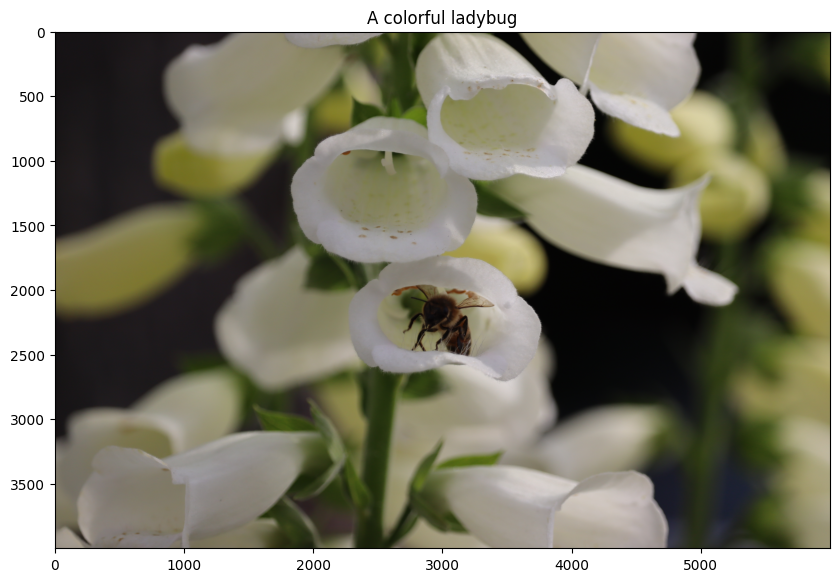

In [27]:
# Display the loaded image
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(im_arr)
ax.set_title('A colorful ladybug')

Dimension of the Red channel image: (4000, 6000)
Dimension of the Green channel image: (4000, 6000)
Dimension of the Blue channel image: (4000, 6000)


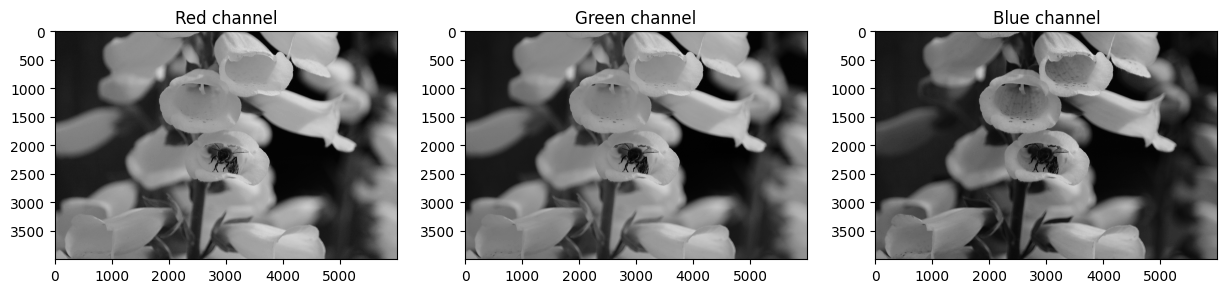

In [28]:
# Display each channel
fig, ax = plt.subplots(1, 3, figsize=(15, 15))
for channel_id, channel_color in enumerate(['Red', 'Green', 'Blue']):
    ax[channel_id].imshow(im_arr[:, :, channel_id],
                          cmap='gray')
    ax[channel_id].set_title('{0} channel'.format(channel_color))
    print('Dimension of the {0} channel image: {1}'.format(channel_color,
    im_arr[:, :, channel_id].shape))

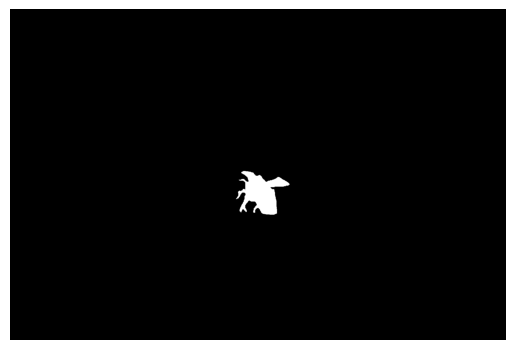

In [29]:
# Load and display the mask image
mask_arr = Image.open(maskpath)
mask_arr = np.array(mask_arr.convert('L'))
plt.imshow(mask_arr, cmap='gray')
plt.axis('off')
plt.show()


In [30]:
print(mask_arr.shape)

(4000, 6000)


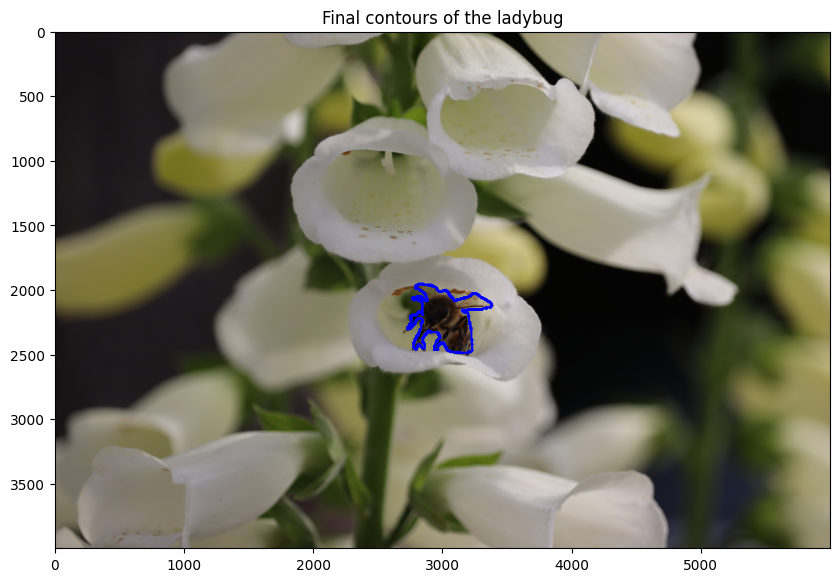

In [31]:
# Display the contours of the segmentation
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(im_arr)
ax.contour(mask_arr, [0.5], colors = 'b');
ax.set_title('Final contours of the ladybug');

In [32]:
[x, y] =  np.where(mask_arr)
print('The ladybug mask is composed of {0} pixels'.format(len(x)))

The ladybug mask is composed of 178273 pixels


Text(0.5, 1.0, 'Centroid and contours of the ladybug')

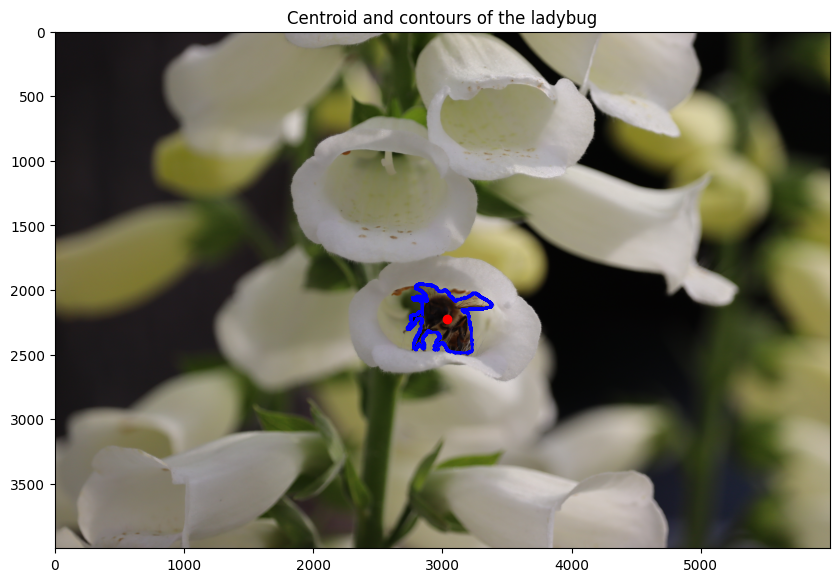

In [33]:
# Compute the centroid of the mask
x0 = np.mean(x)
y0 = np.mean(y)

# Display the centroid and the contours of the mask 
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(im_arr)
ax.contour(mask_arr, [0.5], colors = 'b', linewidths = [2, 2])
ax.plot(y0, x0, 'ro')
ax.set_title('Centroid and contours of the ladybug')

The symmetry index of an object in an image can be calculated by comparing the object with its mirror image. Here's a step-by-step plan:

1. Compute the centroid of the bug's mask as you've done in your code.
2. Flip the mask around the y-axis (vertical axis) using the centroid as the axis of symmetry.
3. Compare the original mask and the flipped mask. The comparison can be done by calculating the absolute difference between the two masks.
4. The symmetry index can be defined as the sum of the absolute differences divided by the total number of pixels in the mask. This will give a value between 0 and 1, where 0 means perfect symmetry and 1 means no symmetry.

Here's how you can implement this in Python:



# **SYMMETRY INDEX**

Symmetry index: 0.39056


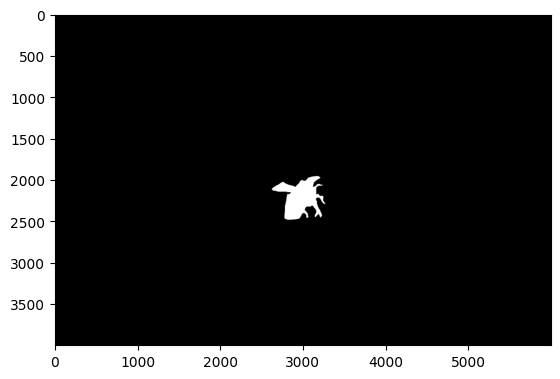

In [34]:
# Flip the mask around the y-axis
flipped_mask = np.fliplr(mask_arr)
plt.imshow(flipped_mask, cmap='gray')
# Calculate the absolute difference between the original and flipped mask
diff = np.abs(mask_arr - flipped_mask)

# Calculate the symmetry index
symmetry_index = np.sum(diff) / np.sum(mask_arr)

print('Symmetry index:', np.round(symmetry_index, 5))



This is a simple method and might not work perfectly for all shapes, especially for complex or irregular shapes. Also, it assumes that the bug is oriented vertically in the image. If the bug is oriented differently, you might need to rotate the image or the mask before calculating the symmetry index.

# **RATIO NUM_PIX_BUG / NUM_PIX_IM**

In [35]:
# Assume mask_arr is your mask array and image is your image array

# Calculate the number of pixels of the bug
num_pixels_bug = np.sum(mask_arr > 0)
print('Number of pixels in the bug:', num_pixels_bug)
# Calculate the number of pixels in the full image
num_pixels_image = im_arr.size
print('Number of pixels in the image:', num_pixels_image)
# Calculate the ratio
ratio = num_pixels_bug / num_pixels_image

print('Ratio:', ratio)

Number of pixels in the bug: 178273
Number of pixels in the image: 72000000
Ratio: 0.0024760138888888887


# **MIN,MAX,MEAN RGB MASK**

In [36]:
# Assuming the bug mask is stored in the variable 'mask_arr' as a numpy array

# Get the RGB values within the bug mask
bug_pixels = im_arr[mask_arr == 1]
# Get the Red, Green, and Blue channels
red_channel = bug_pixels[:, 0]
green_channel = bug_pixels[:, 1]
blue_channel = bug_pixels[:, 2]

# Calculate the minimum, maximum, and mean values for each channel
red_min = np.min(red_channel)
red_max = np.max(red_channel)
red_mean = np.mean(red_channel)

green_min = np.min(green_channel)
green_max = np.max(green_channel)
green_mean = np.mean(green_channel)

blue_min = np.min(blue_channel)
blue_max = np.max(blue_channel)
blue_mean = np.mean(blue_channel)

# Print the results
print("Red Channel - Min: {}, Max: {}, Mean: {}".format(red_min, red_max, red_mean))
print("Green Channel - Min: {}, Max: {}, Mean: {}".format(green_min, green_max, green_mean))
print("Blue Channel - Min: {}, Max: {}, Mean: {}".format(blue_min, blue_max, blue_mean))


Red Channel - Min: 11, Max: 206, Mean: 109.23170731707317
Green Channel - Min: 7, Max: 197, Mean: 101.93834688346884
Blue Channel - Min: 5, Max: 188, Mean: 73.53794037940379


# **MEDIAN,Standard Deviation RGB MASK**

In [37]:
# Calculate median and standard deviation for red channel
red_median = np.median(red_channel)
red_std = np.std(red_channel)

# Calculate median and standard deviation for green channel
green_median = np.median(green_channel)
green_std = np.std(green_channel)

# Calculate median and standard deviation for blue channel
blue_median = np.median(blue_channel)
blue_std = np.std(blue_channel)

# Print the results
print("Red Channel - Median:", red_median, "Standard Deviation:", red_std)
print("Green Channel - Median:", green_median, "Standard Deviation:", green_std)
print("Blue Channel - Median:", blue_median, "Standard Deviation:", blue_std)


Red Channel - Median: 123.0 Standard Deviation: 48.27788209724092
Green Channel - Median: 108.0 Standard Deviation: 47.106042725151994
Blue Channel - Median: 75.0 Standard Deviation: 46.466461338930245


# **RATIO TWO LONGEST ORTHO LINES**

# **HARALICK TEXTURE FEATURE**

In [38]:
# Assuming your image is stored in the variable 'image'
# Convert the image to grayscale if it's not already in grayscale
gray_image = mh.colors.rgb2gray(im_arr)
gray_image = gray_image.astype(np.uint8)
# Calculate the Haralick texture features
haralick_features = mh.features.haralick(gray_image)

# Print the Haralick texture features
print(haralick_features)


[[ 2.56968808e-03  1.44796833e+00  9.99788929e-01  3.43005482e+03
   7.16705281e-01  2.05852707e+02  1.37187713e+04  8.41867751e+00
   9.42463745e+00  1.59914497e-03  1.52120634e+00 -7.37143256e-01
   9.99991670e-01]
 [ 2.06774763e-03  2.55023266e+00  9.99628254e-01  3.43007495e+03
   6.49999144e-01  2.05854455e+02  1.37177496e+04  8.44199981e+00
   9.73902170e+00  1.39581160e-03  1.74901609e+00 -6.95018120e-01
   9.99984379e-01]
 [ 2.55701976e-03  1.57758602e+00  9.99770044e-01  3.43018376e+03
   7.21143025e-01  2.05849506e+02  1.37191574e+04  8.42203550e+00
   9.42272268e+00  1.61487352e-03  1.51512817e+00 -7.37399102e-01
   9.99991702e-01]
 [ 2.06409653e-03  2.57160414e+00  9.99625139e-01  3.43007487e+03
   6.49357018e-01  2.05854457e+02  1.37177279e+04  8.44218452e+00
   9.75179016e+00  1.39324001e-03  1.76038113e+00 -6.93307206e-01
   9.99983975e-01]]


# **ECCENTRICITY FEATURE**

In [45]:
# Calculate properties of labeled regions
props = regionprops(mask_arr, mask_arr)

# Get the eccentricity of the first region
# Please note that if your mask has multiple regions, you'll need to loop over them
eccentricity = props[0].eccentricity

print('Eccentricity:', eccentricity)

Eccentricity: 0.5668988721738824


# **KURTHOSIS FEATURE**

In [50]:
# Assuming im_arr is your image array and mask_arr is your mask
# Apply the mask to the image
masked_im = im_arr * mask_arr[:,:,None]

# Flatten the array to 1D for the calculation
flattened_im = masked_im.flatten()

# Calculate kurtosis
kurt = kurtosis(flattened_im)

print('Kurtosis:', kurt)

Kurtosis: 151.4288259084103
